Much of what you see in this notebook is borrowed from the fabulous book, "Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow," by Aurelion Geron. You may access his Jupyter Notebooks at https://github.com/ageron/handson-ml2. 

In [1]:
import pandas as pd
data = pd.read_csv("/Users/snerur/Dropbox/insy5378/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
#Let us get some information about the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


What can we tell about the columns and the data? First, there are 20640 observations or instances in the dataset. Note that total_bedrooms is missing some values. To be precise, it is missing 20640 - 20433 (207) values. The cell below shows you how to check for the proportion of missing values in any column. We need to deal with it....Also, notice that ocean_proximity is a categorical variable. Let us take a look at the categories respresented in ocean_proximity. 

In [3]:
data.total_bedrooms.value_counts(dropna=False, normalize=True).head()

NaN      0.010029
280.0    0.002665
331.0    0.002471
345.0    0.002422
343.0    0.002374
Name: total_bedrooms, dtype: float64

In [3]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Let us look at some summary statistics for the numerical columns.

In [4]:
data.describe().T #I prefer to transpose the results

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


These numbers are quite useful for understanding the dataset. We can also plot the histograms of the columns to get a feel for the distribution of data.

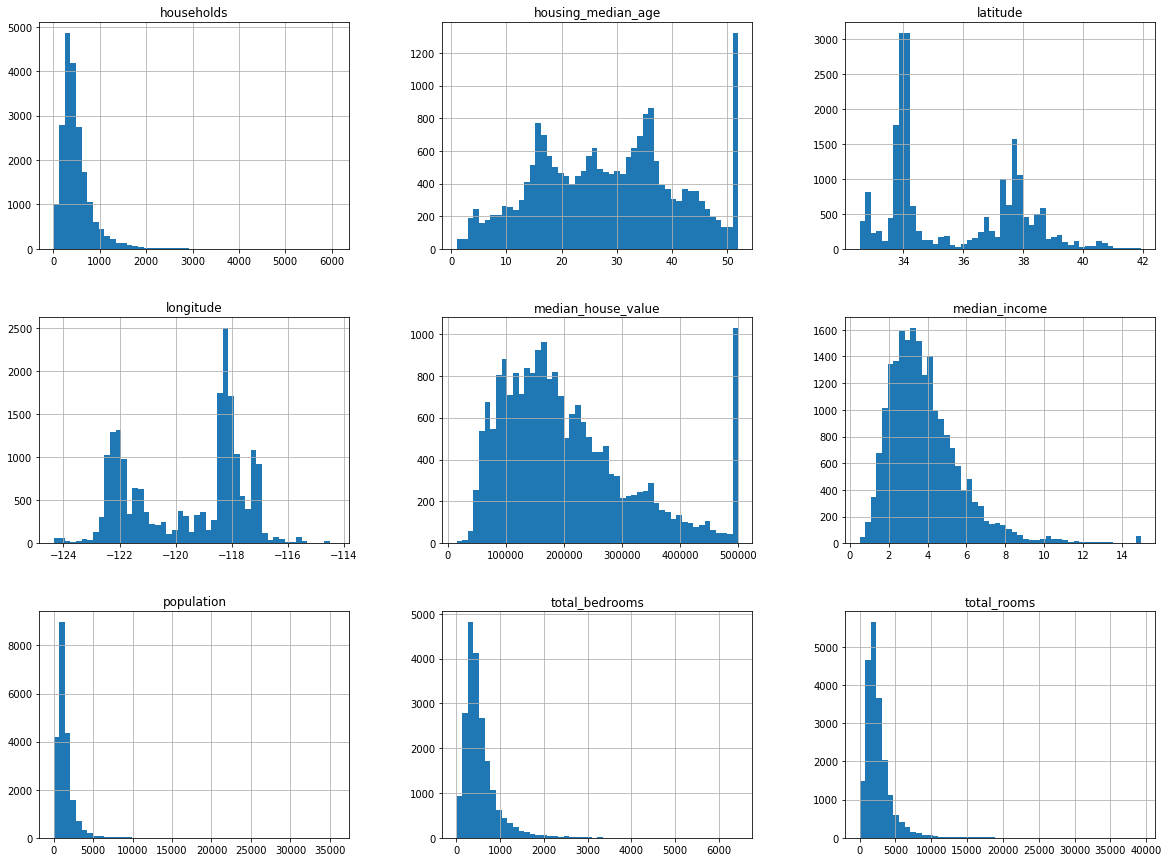

In [6]:
#render within the notebook or use Jupyter as backend
%matplotlib inline 
import matplotlib.pyplot as plt
data.hist(bins = 50, figsize = (20, 15))
plt.show()

Some points to note:

1. Median income: Note that the values are from close to 0 to about 15. It turns out that the data was previously scaled and is in 10s of thousands of dollars. That is, 3 would be approximately $30,000.

2. Can you see the problem with housing_median_age and median_house_value? They have both been capped, which means that everything above a threshold was lumped together. Since median_house_value is what we are trying to predict, this can be problematic for predictions beyond $500,000. To fix this, you have to find the correct values for the ones that were capped or drop everything beyond $500,000. 

3. Also, notice that we may have to scale the data as they are not on the same scale. Why is this a problem? What would you use for scaling?

4. You can also see that many of the histograms are right-skewed (i.e., positively skewed) or heavy-tailed. Some machine learning algorithms don't work well with skewed data.

No handles with labels found to put in legend.


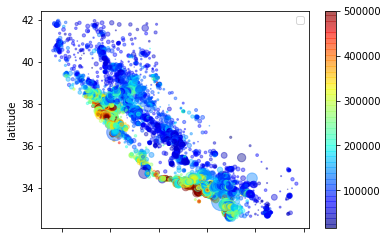

In [7]:
#Let us plot using latitude and longitude to see get a sense of how
#the median house value changes across California using different colors;
#we will also use size (s) to represent the populaation density
data.plot(kind='scatter', x="longitude", y = "latitude", alpha = 0.4,
         s = data['population']/100, c = data['median_house_value'],
         cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
plt.show()

Not surprisingly, housing prices are high in the Bay Area, LA, and San Diego along the coastline. Let us look at the correlations among the variables.

In [8]:
correlations = data.corr()
correlations

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


In [9]:
#Since we wish to predict median house value, let us look at how it is
#correlated with other variables sorted from highest to lowest
correlations['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

Looks like median income is a strong predictor of median house value, at least based on its correlation with the latter. We can also look at a scatter plot to get a sense of how each variable is correlated with the rest.

Here is a nice way to show correlations....

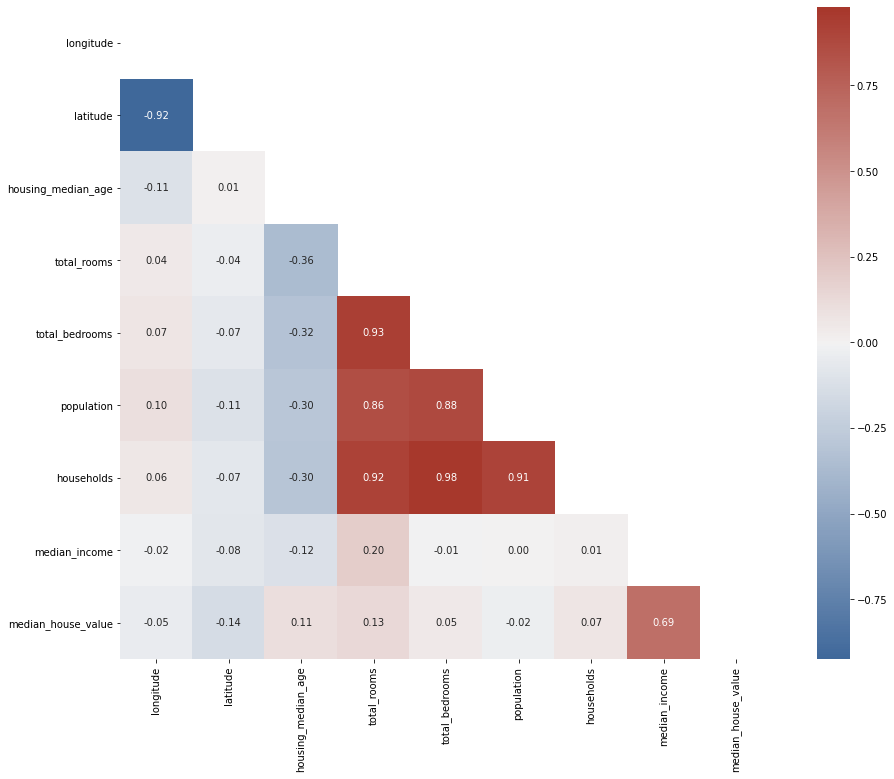

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Calculate pairwise-correlation
matrix = data.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();

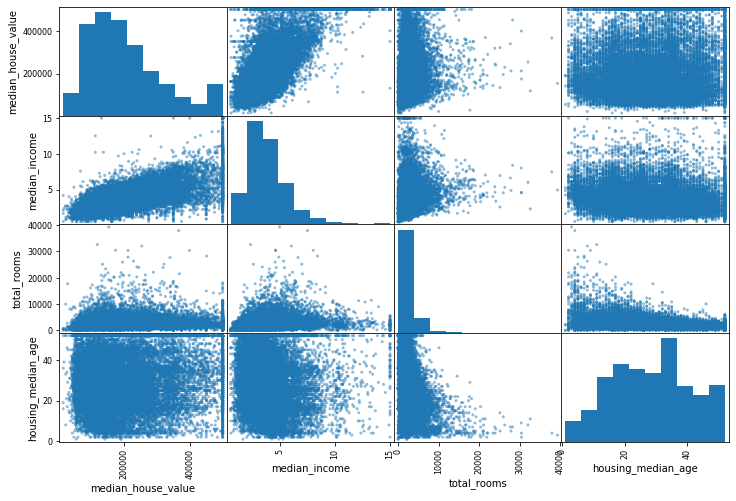

In [11]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value","median_income","total_rooms",
             "housing_median_age"]
scatter_matrix(data[attributes], figsize=(12, 8))
plt.show()

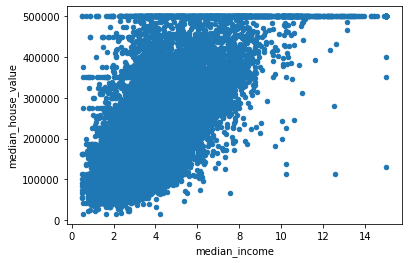

In [54]:
#Let us zoom into median_income vs _median_house_value
data.plot(kind = "scatter", x = "median_income", y = "median_house_value")
plt.show()

Combining some of the attributes:

Total number of rooms in the district may not be as useful as the total number of rooms per household. Likewise, the number of bedrooms by itself may not be as informative as the ratio of number of bedrooms to total number of rooms. Finally, the ratio of population to households may be quite useful as well. Let us create these three ratios and see how they correlate with the median house value.

In [12]:
data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']

In [13]:
correlations = data.corr()
correlations['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

You can see that bedrooms_per_room is quite useful (houses with smaller bedrooms to total rooms ratio are more expensive). 

You may recall that total bedrooms had some missing values. How would you deal with missing values? There are several approaches:

a. Drop the rows that have missing values 
    data.dropna(subset = ['total_bedrooms'], inplace = True)

b. Drop the entire column
    data.drop('total_bedrooms', axis = 1, inplace = True)

c. Replace missing values with mean, median, mode, zero, or some other value
    median = data['total_bedrooms'].median()
    data['total_bedrooms'].fillna(median, inplace = True)
    
    You could use Scikit-Learn's SimpleImputer for this purpose. Note that SimpleImputer works only on numerical columns, so "ocean_proximity" must be removed before you do the imputation. Here is how you would use the SimpleImputer:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy = 'median') 
    #can be mean, median, "most_frequent", or constant (specified in           #fill_value)
    result = imputer.fit_transform(data)
    #result will be a numpy array with the transformed columns

d. You may use a more sophisticated imputer (e.g., nearest neighbor imputation) to impute values. There are at least two packages (perhaps more) that allow you to do some sophisticated imputations. The following link may be useful to understand imputation: https://projector-video-pdf-converter.datacamp.com/17404/chapter4.pdf. 

We will try one of these on the dataset...however, we will create a copy of our dataframe before we mess with things!
    

In [16]:
from fancyimpute import KNN
data_copy = data.copy()

In [17]:
#Let us remove the 'ocean proximity' column before doing the imputation
data_copy.drop('ocean_proximity', axis = 1, inplace = True)

In [18]:
imputed_matrix = KNN(k = 3).fit_transform(data_copy)

Imputing row 1/20640 with 0 missing, elapsed time: 47.876
Imputing row 101/20640 with 0 missing, elapsed time: 47.876
Imputing row 201/20640 with 0 missing, elapsed time: 47.877
Imputing row 301/20640 with 0 missing, elapsed time: 47.878
Imputing row 401/20640 with 0 missing, elapsed time: 47.878
Imputing row 501/20640 with 0 missing, elapsed time: 47.879
Imputing row 601/20640 with 0 missing, elapsed time: 47.879
Imputing row 701/20640 with 0 missing, elapsed time: 47.880
Imputing row 801/20640 with 0 missing, elapsed time: 47.880
Imputing row 901/20640 with 0 missing, elapsed time: 47.880
Imputing row 1001/20640 with 0 missing, elapsed time: 47.881
Imputing row 1101/20640 with 0 missing, elapsed time: 47.881
Imputing row 1201/20640 with 0 missing, elapsed time: 47.882
Imputing row 1301/20640 with 0 missing, elapsed time: 47.882
Imputing row 1401/20640 with 0 missing, elapsed time: 47.883
Imputing row 1501/20640 with 0 missing, elapsed time: 47.884
Imputing row 1601/20640 with 0 missi

In [19]:
#imputed matrix will be a Numpy array...let us put it in a dataframe
imputed_data = pd.DataFrame(imputed_matrix, columns = data_copy.columns,
                           index = data_copy.index)

In [20]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   rooms_per_household       20640 non-null  float64
 10  bedrooms_per_room         20640 non-null  float64
 11  population_per_household  20640 non-null  float64
dtypes: float64(12)
memory usage: 1.9 MB


No missing values!! Let us get the descriptive stats...

In [21]:
imputed_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.584011,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213004,3.070655
std,2.003532,2.135952,12.585558,2181.615252,420.509777,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057825,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175499,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203179,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239698,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [23]:
#Let us try a different algorithm - 
#Multivariate Imputation by Chained Equations (MICE)
from fancyimpute import IterativeImputer
imputer = IterativeImputer()
m_data = imputer.fit_transform(data_copy)

In [26]:
m_data_df = pd.DataFrame(m_data, columns = data_copy.columns,
                        index = data_copy.index)
m_data_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.899932,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213084,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.170838,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057875,10.386050
min,-124.350000,32.540000,1.000000,2.000000,-65.160780,3.000000,1.000000,0.499900,14999.000000,0.846154,0.031783,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175552,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203409,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239794,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [27]:
#You could also use sklearn's iterative imputer to do the same thing -
#in fact, they are identical
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(random_state = 99)
s_data = imputer.fit_transform(data_copy)

In [29]:
s_data_df = pd.DataFrame(s_data, columns = data_copy.columns,
                        index = data_copy.index)
s_data_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.899932,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213084,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.170838,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057875,10.386050
min,-124.350000,32.540000,1.000000,2.000000,-65.160780,3.000000,1.000000,0.499900,14999.000000,0.846154,0.031783,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175552,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203409,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239794,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


So, now you know how to deal with missing values. Let us convert our categorical column to numbers, as our machine learning algorithms need numeric data.

In this dataset, we have only one categorical column, namely, 'ocean_proximity'. There are several ways to do it. We could first encode the categories using an OrdinalEncoder. This is appropriate when you have categories such as "Low", "Medium", and "High", or text showing progressive improvement from "Bad" to "Excellent". In these cases, it is perhaps reasonable to expect that the difference between low and medium is about the same as the difference between medium and high. However, our data is quite different, and, therefore, we are better off one-hot encoding the column. Pandas has a method called get_dummies() which also does this. Examples of these are shown below. 

In [39]:
#Let us first look at the ocean_proximity column
cat = data[['ocean_proximity']]
cat.sample(frac = 0.0005,random_state = 99 ) #randomly sample a small fraction


,ocean_proximity
7914,<1H OCEAN
11963,INLAND
18738,INLAND
17431,NEAR OCEAN
17947,<1H OCEAN
5740,<1H OCEAN
17674,<1H OCEAN
16338,INLAND
3887,<1H OCEAN
439,NEAR BAY


In [45]:
#Let us use an OrdinalEncoder on this
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
encoded_cat = encoder.fit_transform(cat)
df = pd.DataFrame(encoded_cat, columns = ["ocean_proximity"])
df.sample(frac = 0.0005,random_state = 99 )

,ocean_proximity
7914,0.0
11963,1.0
18738,1.0
17431,4.0
17947,0.0
5740,0.0
17674,0.0
16338,1.0
3887,0.0
439,3.0


In [50]:
#Let us do one-hot coding now
from sklearn.preprocessing import OneHotEncoder
one_encoder = OneHotEncoder()
one_encoded_cat = one_encoder.fit_transform(cat)
one_encoded_cat.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [51]:
df = pd.DataFrame(one_encoded_cat.toarray(), columns = one_encoder.categories_)
df.sample(frac = 0.0005,random_state = 99 )

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
7914,1.0,0.0,0.0,0.0,0.0
11963,0.0,1.0,0.0,0.0,0.0
18738,0.0,1.0,0.0,0.0,0.0
17431,0.0,0.0,0.0,0.0,1.0
17947,1.0,0.0,0.0,0.0,0.0
5740,1.0,0.0,0.0,0.0,0.0
17674,1.0,0.0,0.0,0.0,0.0
16338,0.0,1.0,0.0,0.0,0.0
3887,1.0,0.0,0.0,0.0,0.0
439,0.0,0.0,0.0,1.0,0.0


Notice that we have now have 5 dummy attributes, one for each category. Let us see what get_dummies() does.

In [53]:
pd.get_dummies(cat).sample(frac = 0.0005,random_state = 99 )

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
7914,1,0,0,0,0
11963,0,1,0,0,0
18738,0,1,0,0,0
17431,0,0,0,0,1
17947,1,0,0,0,0
5740,1,0,0,0,0
17674,1,0,0,0,0
16338,0,1,0,0,0
3887,1,0,0,0,0
439,0,0,0,1,0


Dealing with skewed data

Let us examine one of the columns that appears to be positively/right skewed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11dc92ac8>]],
      dtype=object)

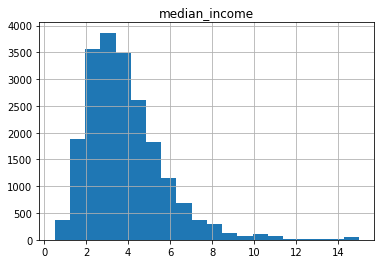

In [55]:
data[['median_income']].hist(bins = 20)

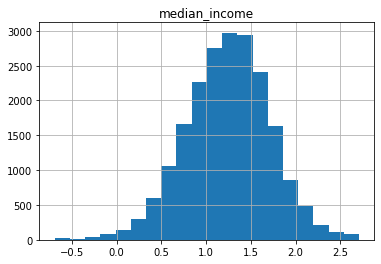

In [59]:
#We will use Box-Cox to transform the data - it takes a lambda parameter
#that determines the type of transformation:
#lambda = -1. is a reciprocal transform.
#lambda = -0.5 is a reciprocal square root transform.
#lambda = 0.0 is a log transform.
#lambda = 0.5 is a square root transform.
#lambda = 1.0 is no transform.
#See https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/

from scipy.stats import boxcox
mi_data = boxcox(data['median_income'], 0) #try a log transform
pd.DataFrame(mi_data, columns = ['median_income']).hist(bins = 20)
plt.show()


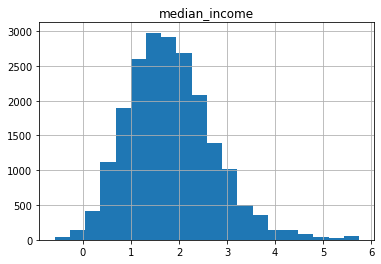

In [60]:
#Let us try a square root transform
from scipy.stats import boxcox
mi_data = boxcox(data['median_income'], 0.5) #try a log transform
pd.DataFrame(mi_data, columns = ['median_income']).hist(bins = 20)
plt.show()

We can also use Power Transformation (see https://machinelearningmastery.com/power-transforms-with-scikit-learn/) as shown below.

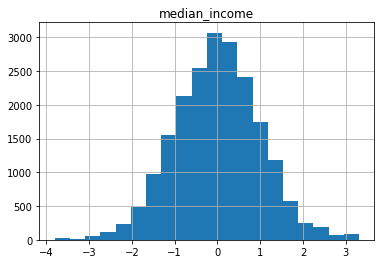

In [64]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='box-cox')
pt_data = pt.fit_transform(data[['median_income']].values.reshape(-1, 1))
pd.DataFrame(pt_data, columns = ['median_income']).hist(bins = 20)
plt.show()

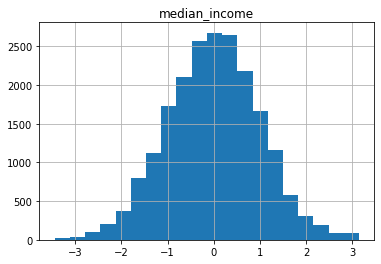

In [65]:
#Box-Cox works only for positive values. If you have negative values
#and/or zeroes, use Yeo-Johnson
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt_data = pt.fit_transform(data[['median_income']].values.reshape(-1, 1))
pd.DataFrame(pt_data, columns = ['median_income']).hist(bins = 20)
plt.show()

Discretizing data

There are times when one may want to discretize continuous data. A KBinsDiscretizer from sklearn can be used for this purpose. An example for discretizing median income is shown below.

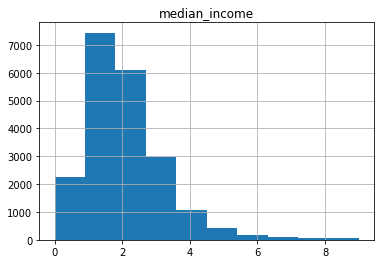

In [68]:
from sklearn.preprocessing import KBinsDiscretizer
transformer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
kb_data = transformer.fit_transform(data['median_income'].values.reshape(-1,1))
pd.DataFrame(kb_data, columns = ['median_income']).hist(bins = 10)
plt.show()

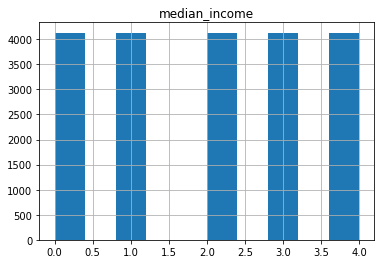

In [72]:
#let us try a different strategy
transformer = KBinsDiscretizer(n_bins=5, encode='ordinal',
                               strategy='quantile')
kb_data = transformer.fit_transform(data['median_income'].values.reshape(-1,1))
pd.DataFrame(kb_data, columns = ['median_income']).hist(bins = 10)
plt.show()

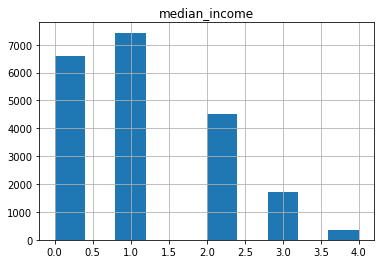

In [73]:
#Using kmeans strategy
transformer = KBinsDiscretizer(n_bins=5, encode='ordinal',
                               strategy='kmeans')
kb_data = transformer.fit_transform(data['median_income'].values.reshape(-1,1))
pd.DataFrame(kb_data, columns = ['median_income']).hist(bins = 10)
plt.show()

You may also use the cut() method available in Pandas. 

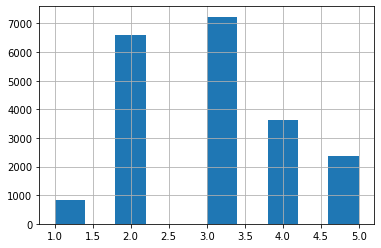

In [75]:
import numpy as np
data['income_category'] = pd.cut(data['median_income'],
                                bins = [0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                                labels = [1, 2, 3, 4, 5])
data['income_category'].hist()